
Из Банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель:** спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

**Задачи:** 
1. Построить модель с предельно большим значением F1-меры.
2. Измерить AUC-ROC, сравнить её значение с F1-мерой.

**Ход работы:**
1. Загрузить и подготовить данные. Пояснить порядок действий.
2. Исследовать баланс классов, обучить модель без учёта дисбаланса. Кратко описать выводы.
3. Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую. Кратко описать выводы.
4. Провести финальное тестирование.

# Загрузка и изучение данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn import tree

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('.\\data\\Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


*Признаки*

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

*Целевой признак*

* Exited — факт ухода клиента

In [3]:
# Явных дубликатов нет
data.loc[data.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [4]:
# Проверка на неявные дубликаты
# Посмотрим, есть ли одинаковые id
data_duplicated_one = data[['CustomerId']]
data_duplicated_one[data_duplicated_one.duplicated()]

,CustomerId


In [5]:
# Дубликатов нет
# Удаляем лишниe столбцы
data = data.drop(['RowNumber', "CustomerId", 'Surname'], axis = 1)

In [6]:
print('Размер датафрейма:', data.shape)

Размер датафрейма: (10000, 11)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


> Имеются пропуски в столбце tenure. Вообще,  я бы их оставила(на мой взгляд, тут некорректно чем-то заполнять). Но с пропусками в таблице машина не будет обучаться. Поэтому сначала я проанализирую те данные, которые есть. А перед обучением заполню пропуски

In [8]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [9]:
# Приведем названия колонок к змеиному регистру 
data.columns = data.columns.str.lower()
data.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [10]:
data = data.rename(columns={'creditscore': 'credit_score',
                            'numofproducts': 'num_of_products',
                            'hascrcard': 'has_cr_card',
                            'isactivemember': 'is_active_member', 
                            'estimatedsalary':'estimated_salary', 
                            })

In [11]:
data_visualization = data.copy()
data_visualization.loc[data_visualization['exited']== 0, 'exited'] = 'Ушел из банка'
data_visualization.loc[data_visualization['exited']== 1, 'exited'] = 'Не ушел из банка'
data_visualization.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,Не ушел из банка
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,Ушел из банка
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,Не ушел из банка
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,Ушел из банка
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,Ушел из банка


exited
Ушел из банка       0.7963
Не ушел из банка    0.2037
Name: proportion, dtype: float64


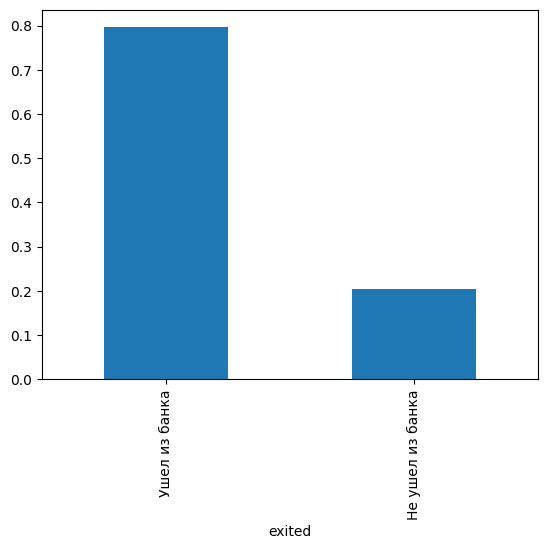

In [12]:
# Доли положительных и отрицательных классов
class_data = data_visualization['exited'].value_counts(normalize = 2/len(data['exited']))
print(class_data)
class_data.plot(kind='bar');

> перевес в сторону тех, кто ушел из банка

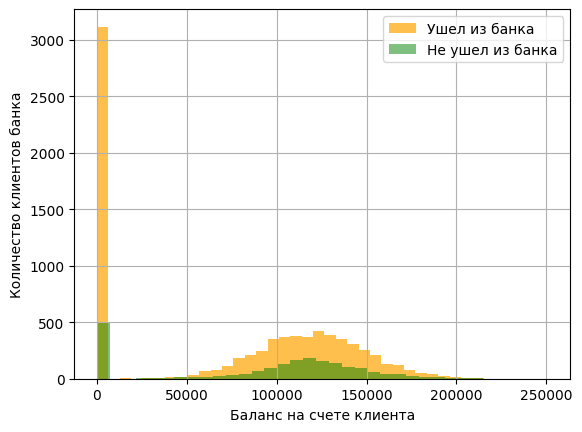

In [13]:
data_visualization[data_visualization['exited'] =='Ушел из банка']['balance'].hist(bins=35, alpha=0.7, color='orange')
data_visualization[data_visualization['exited'] =='Не ушел из банка']['balance'].hist(bins=35, alpha=0.5, color='green');
plt.legend(['Ушел из банка', 'Не ушел из банка'])
plt.xlabel('Баланс на счете клиента')
plt.ylabel('Количество клиентов банка')
plt.show()

> стоит отметить, что из банка также уходят люди, которые не держат счет в банке

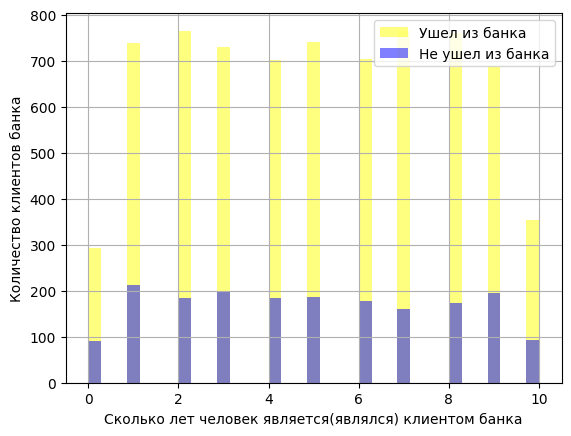

In [14]:
data_visualization[data_visualization['exited'] =='Ушел из банка']['tenure'].hist(bins=35, alpha=0.5, color='yellow')
data_visualization[data_visualization['exited'] =='Не ушел из банка']['tenure'].hist(bins=35, alpha=0.5, color='blue');
plt.legend(['Ушел из банка', 'Не ушел из банка'])
plt.xlabel('Сколько лет человек является(являлся) клиентом банка')
plt.ylabel('Количество клиентов банка')
plt.show()

> Чаще всего из банка уходят люди, которые пробыли клиентами больше 1 года. Даже на 9 году обслуживания клиенты уходят из банка. Но на 10 год часть клиентов, видимо, начинает мириться со всеми условиями банка и остается :)

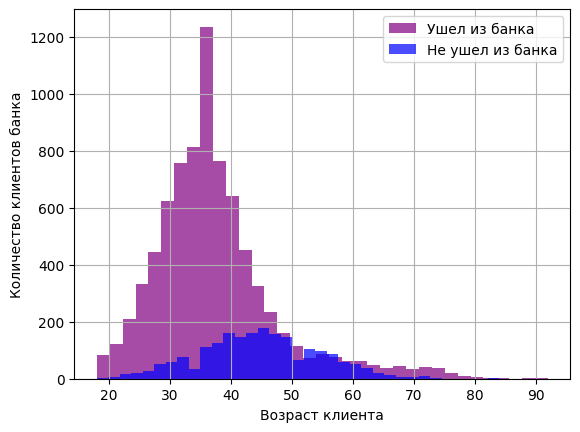

In [15]:
data_visualization[data_visualization['exited'] =='Ушел из банка']['age'].hist(bins=35, alpha=0.7, color='purple')
data_visualization[data_visualization['exited'] =='Не ушел из банка']['age'].hist(bins=35, alpha=0.7, color='blue');
plt.legend(['Ушел из банка', 'Не ушел из банка'])
plt.xlabel('Возраст клиента')
plt.ylabel('Количество клиентов банка')
plt.show()

> Боьшая часть людей в возсрасте 18-45 уходят из банка.

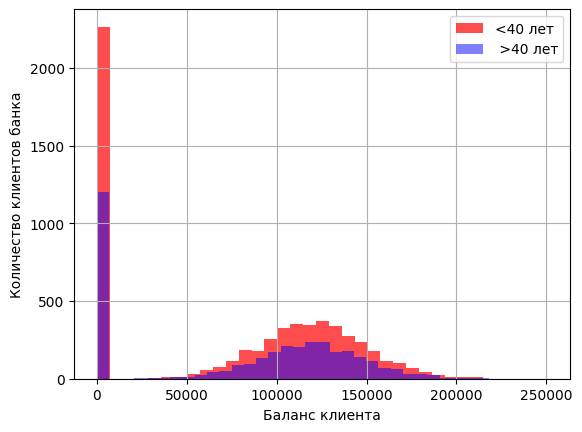

In [16]:
data_visualization[data_visualization['age'] <40]['balance'].hist(bins=35, alpha=0.7, color='red')
data_visualization[data_visualization['age']> 40]['balance'].hist(bins=35, alpha=0.5, color='blue');
plt.legend(['<40 лет', ' >40 лет'])
plt.xlabel('Баланс клиента')
plt.ylabel('Количество клиентов банка')
plt.show()

 > Люди до 40 лет чуть лучше откладывают деньги) Но эта информация не принесла большого толку 

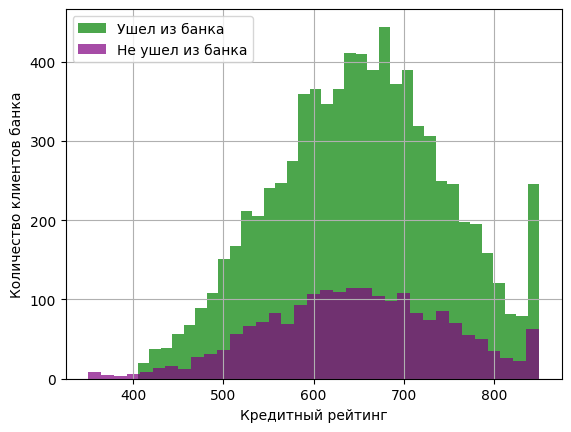

In [17]:
data_visualization[data_visualization['exited'] =='Ушел из банка']['credit_score'].hist(bins=35, alpha=0.7, color='green')
data_visualization[data_visualization['exited'] =='Не ушел из банка']['credit_score'].hist(bins=35, alpha=0.7, color='purple');
plt.legend(['Ушел из банка', 'Не ушел из банка'])
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Количество клиентов банка')
plt.show()

Под кредитным рейтингом понимается оценка потенциального заемщика с точки зрения его кредитоспособности и возможности добросовестно исполнять взятые на себя финансовые обязательства. На практике этот показатель используется при принятии решения об одобрении кредита конкретному клиенту.

Градация баллов выглядит так:

* 1 – 710 баллов: очень низкий, получить кредит практически невозможно.
* 711 – 808 баллов: средний, получить деньги будет непросто.
* 809 – 890 баллов: хороший, получить заем будет легко.
* 891 – 999 баллов: очень хороший, банки выстраиваются в очередь со своими предложениями

Среди тех, кто уходит из банка, довольно низкий кредитный рейтинг. Но он может быть низким из-за того, что клиент вовсе не берет кредиты, а просто является держателем карты этого банка

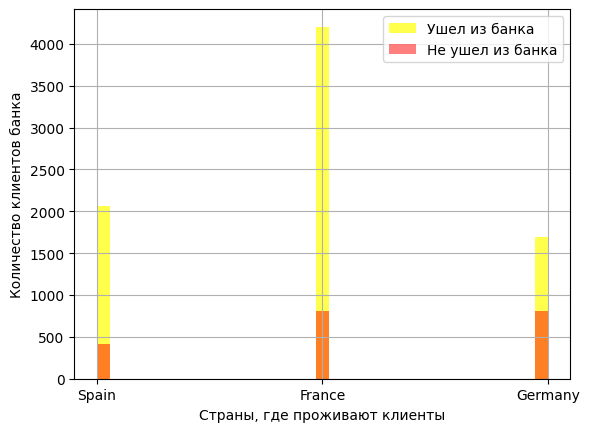

In [18]:
data_visualization[data_visualization['exited'] =='Ушел из банка']['geography'].hist(bins=35, alpha=0.7, color='yellow')
data_visualization[data_visualization['exited'] =='Не ушел из банка']['geography'].hist(bins=35, alpha=0.5, color='red');
plt.legend(['Ушел из банка', 'Не ушел из банка'])
plt.xlabel('Страны, где проживают клиенты')
plt.ylabel('Количество клиентов банка')
plt.show()

> Банком больше пользуются французы. Оттуда и больший отток клиентов

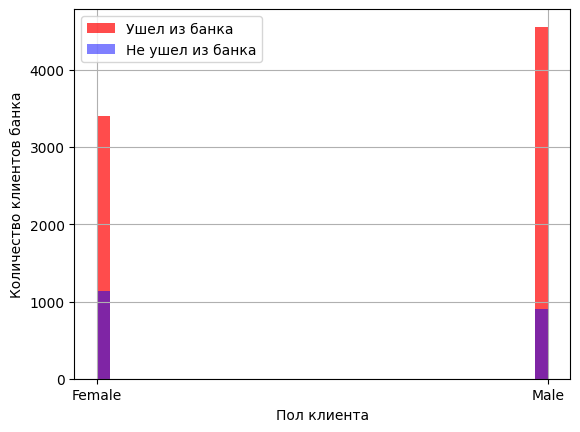

In [19]:
data_visualization[data_visualization['exited'] =='Ушел из банка']['gender'].hist(bins=35, alpha=0.7, color='red')
data_visualization[data_visualization['exited'] =='Не ушел из банка']['gender'].hist(bins=35, alpha=0.5, color='blue');
plt.legend(['Ушел из банка', 'Не ушел из банка'])
plt.xlabel('Пол клиента')
plt.ylabel('Количество клиентов банка')
plt.show()

> Пол тоже никакой зацепки не несет

In [20]:
# Посчитаем пропуски в процентах
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('BuPu')

,0
credit_score,0.000000
geography,0.000000
gender,0.000000
age,0.000000
tenure,9.000000
balance,0.000000
num_of_products,0.000000
has_cr_card,0.000000
is_active_member,0.000000
estimated_salary,0.000000


> Tenure — сколько лет человек является клиентом банка

In [21]:
data.loc[data['tenure'].isna()]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [22]:
data['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [23]:
data.groupby('tenure')['tenure'].count()

tenure
0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
Name: tenure, dtype: int64

In [24]:
# Обработаем столбец tenure в процентах
pd.DataFrame((data.groupby('tenure')['tenure'].count()/len(data)*100)).style.background_gradient('Reds')

,tenure
tenure,
0.000000,3.820000
1.000000,9.520000
2.000000,9.500000
3.000000,9.280000
4.000000,8.850000
5.000000,9.270000
6.000000,8.810000
7.000000,9.250000
8.000000,9.330000


In [25]:
print('Количество пропусков в столбце tenure:', data['tenure'].isna().sum())

Количество пропусков в столбце tenure: 909


> Чтобы не создавать сильную нагрузку у одного значения(все 909 пропусков заменить одним значением). Постараемся отдать одному значению  по ~83  штук пропусков. 909 на 11(tenure от 0 до 10 = 11) делится с остатком. Отдадим четырем значениям с меньшим процентом пропуска( менее вероятнее встретить клиента с таким количеством лет сотрудничесва с банком) по 82, остальным 83

In [26]:
limits = [82, 83, 83, 83, 83, 83, 82, 83, 83, 82, 82]

for i, limit in enumerate(limits):
    data['tenure'] = data['tenure'].fillna(i, limit=limit)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [28]:
pd.DataFrame((data.groupby('tenure')['tenure'].count()/len(data)*100)).style.background_gradient('PuBuGn')

,tenure
tenure,
0.000000,4.640000
1.000000,10.350000
2.000000,10.330000
3.000000,10.110000
4.000000,9.680000
5.000000,10.100000
6.000000,9.630000
7.000000,10.080000
8.000000,10.160000


😇 

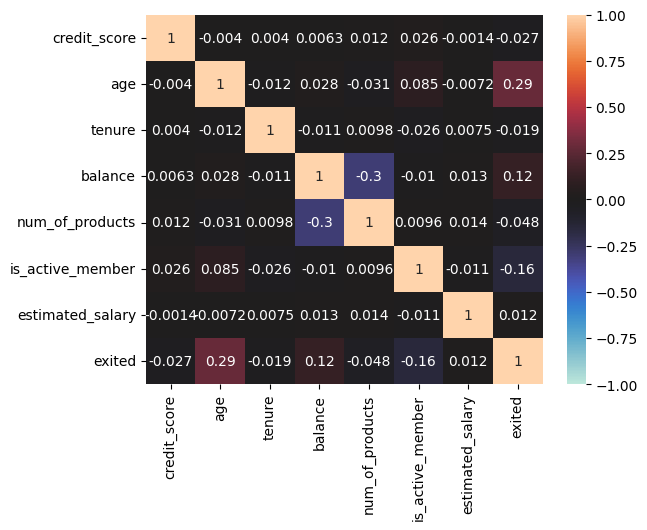

In [29]:
# Посмотрим на мультиколлинеарность без наличия кредитной карты
sns.heatmap(data.select_dtypes(include=[np.number]).drop(['has_cr_card'], axis =1).corr(), annot = True, vmin=-1, vmax=1, center= 0);

> В данных мало каких-то зависимостей. Но кое-что моему глазу приглянулось:
> * Большая часть среди тех, кто ушел из банка, на счету не держали деньги
> *  Боьшая часть людей в возсрасте 18-45 уходят из банка.
> * Среди тех, кто уходит из банка, довольно низкий кредитный рейтинг. (но рейтинг может быть низким по разным причинам, например, клиент вовсе не берет кредиты)

In [30]:
data_leave = data_visualization.loc[data_visualization['exited'] =='Ушел из банка'].reset_index(drop=True)

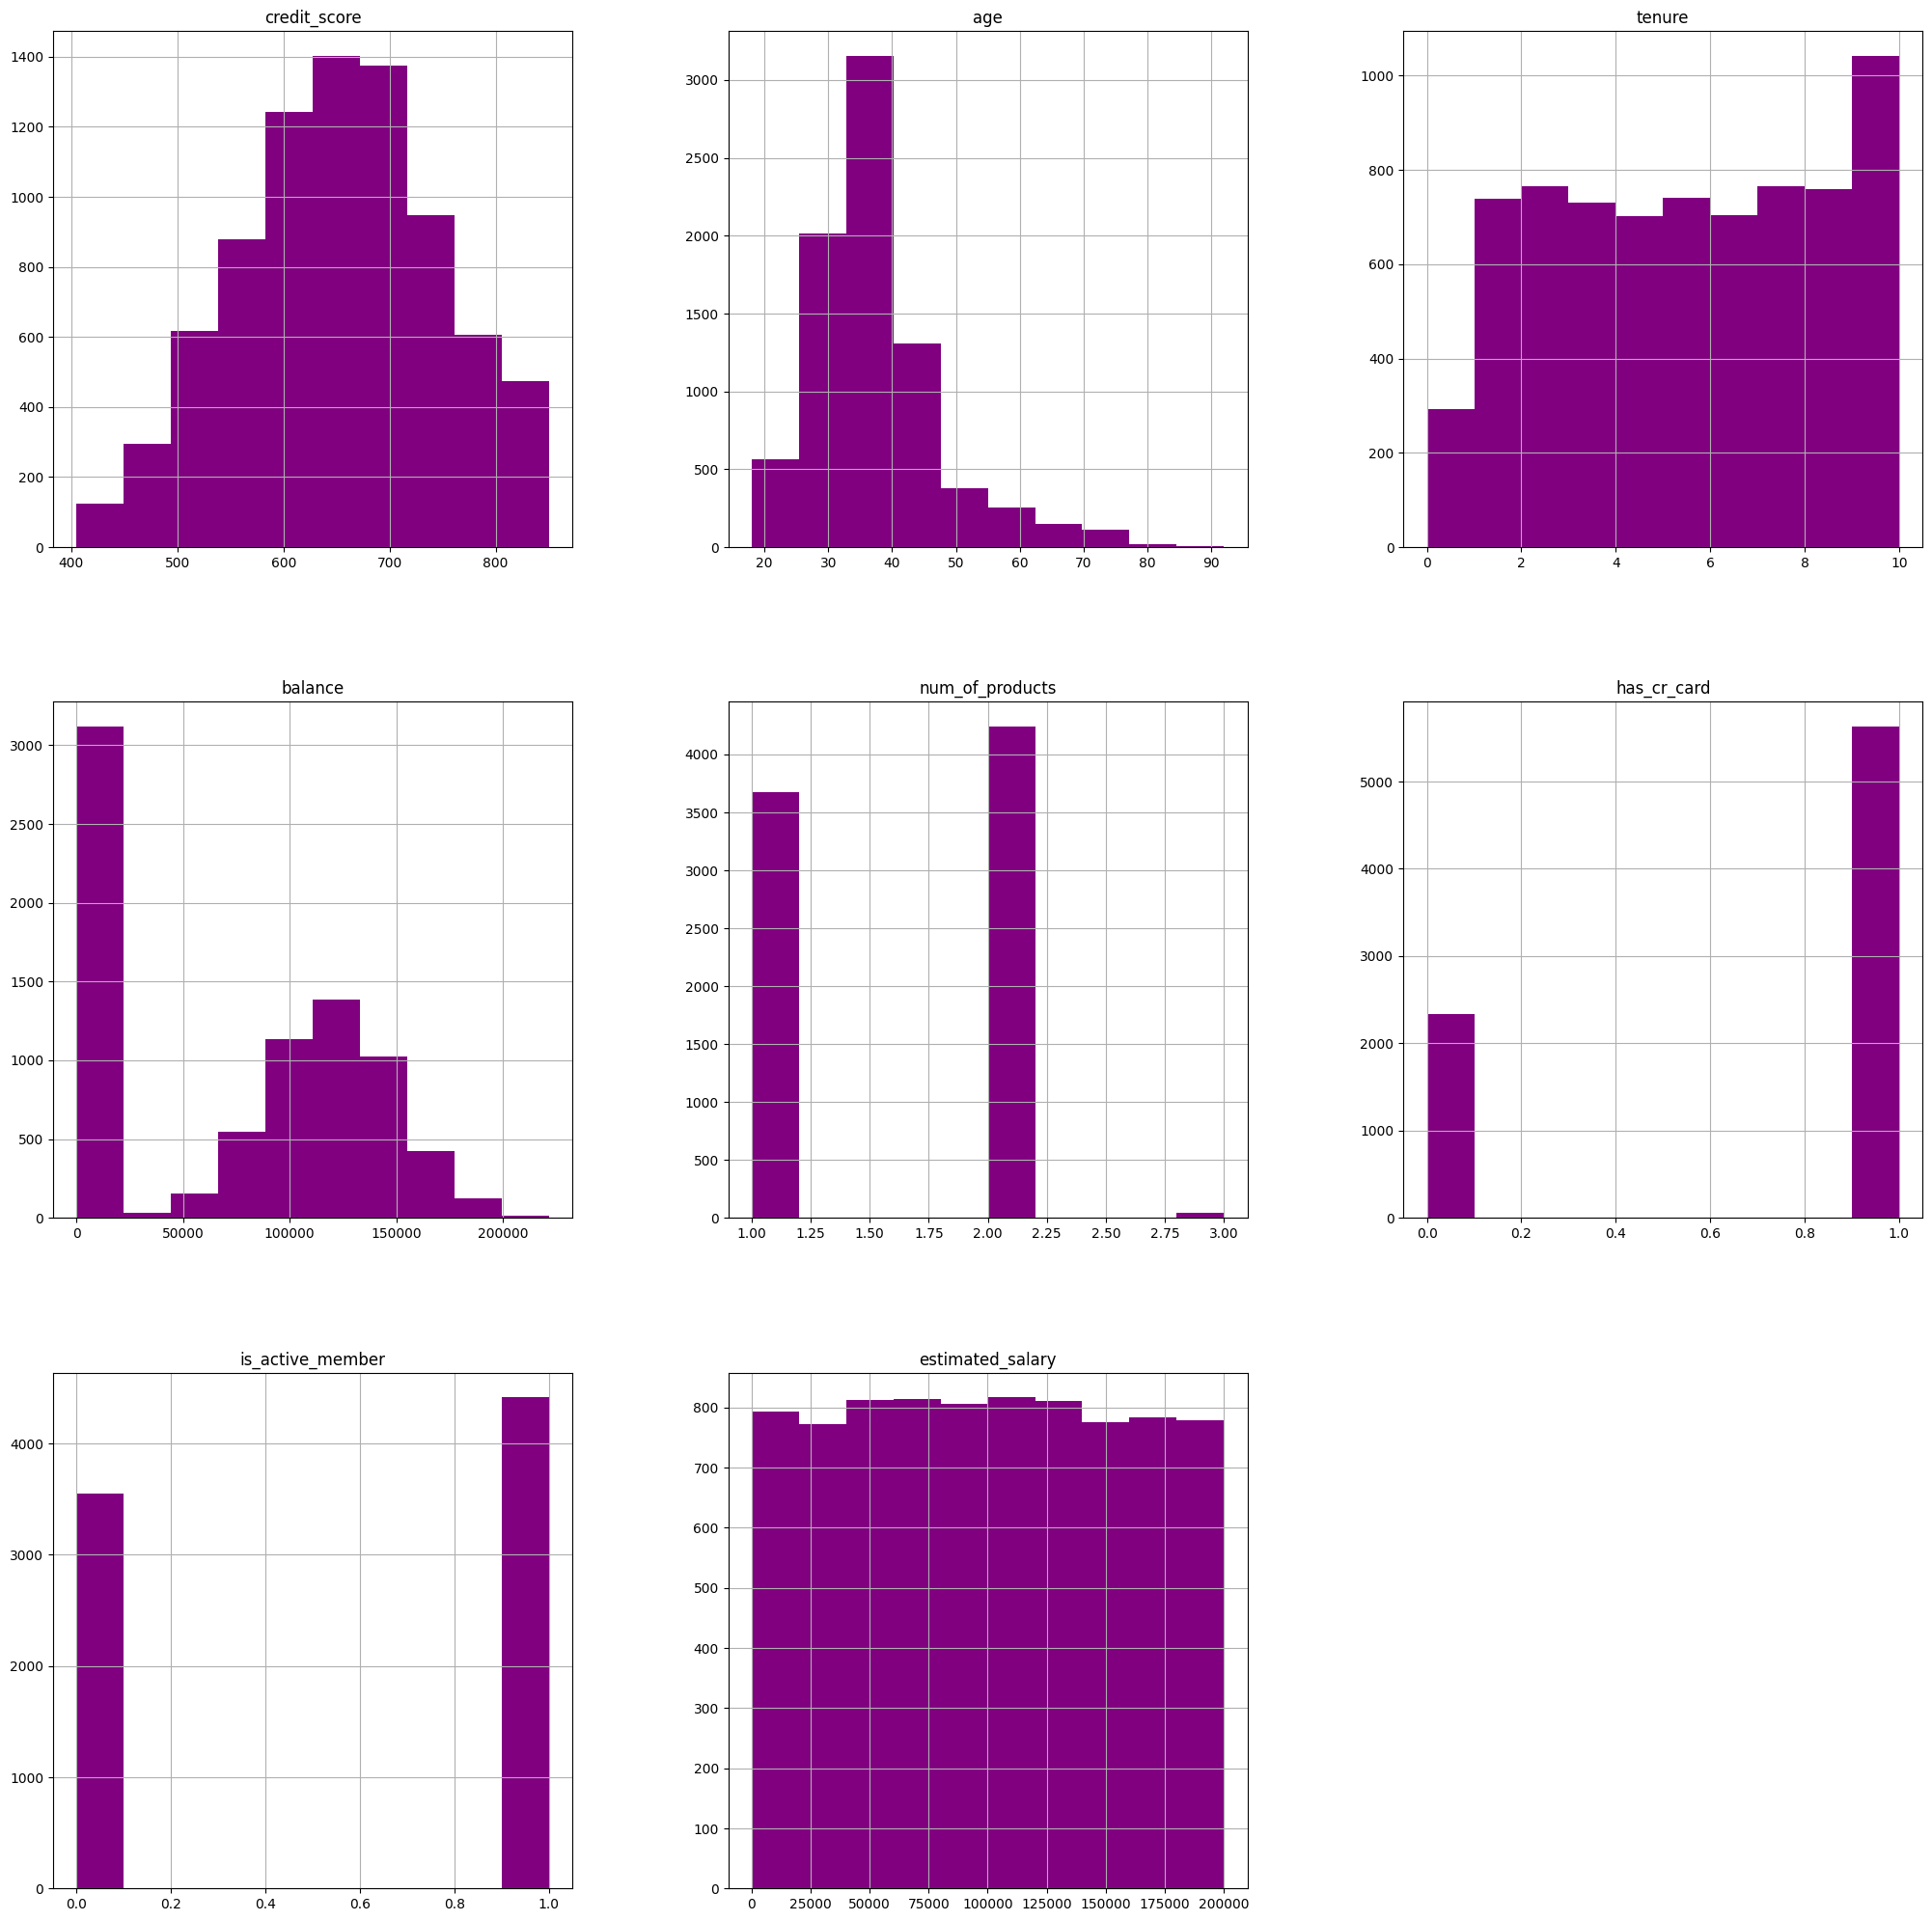

In [31]:
# Визуализация признаков среди тех, кто ушел из банка
data_leave.hist(figsize = (25,25), color = 'purple');

In [32]:
data_stay = data_visualization.loc[data_visualization['exited'] =='Не ушел из банка'].reset_index(drop=True)

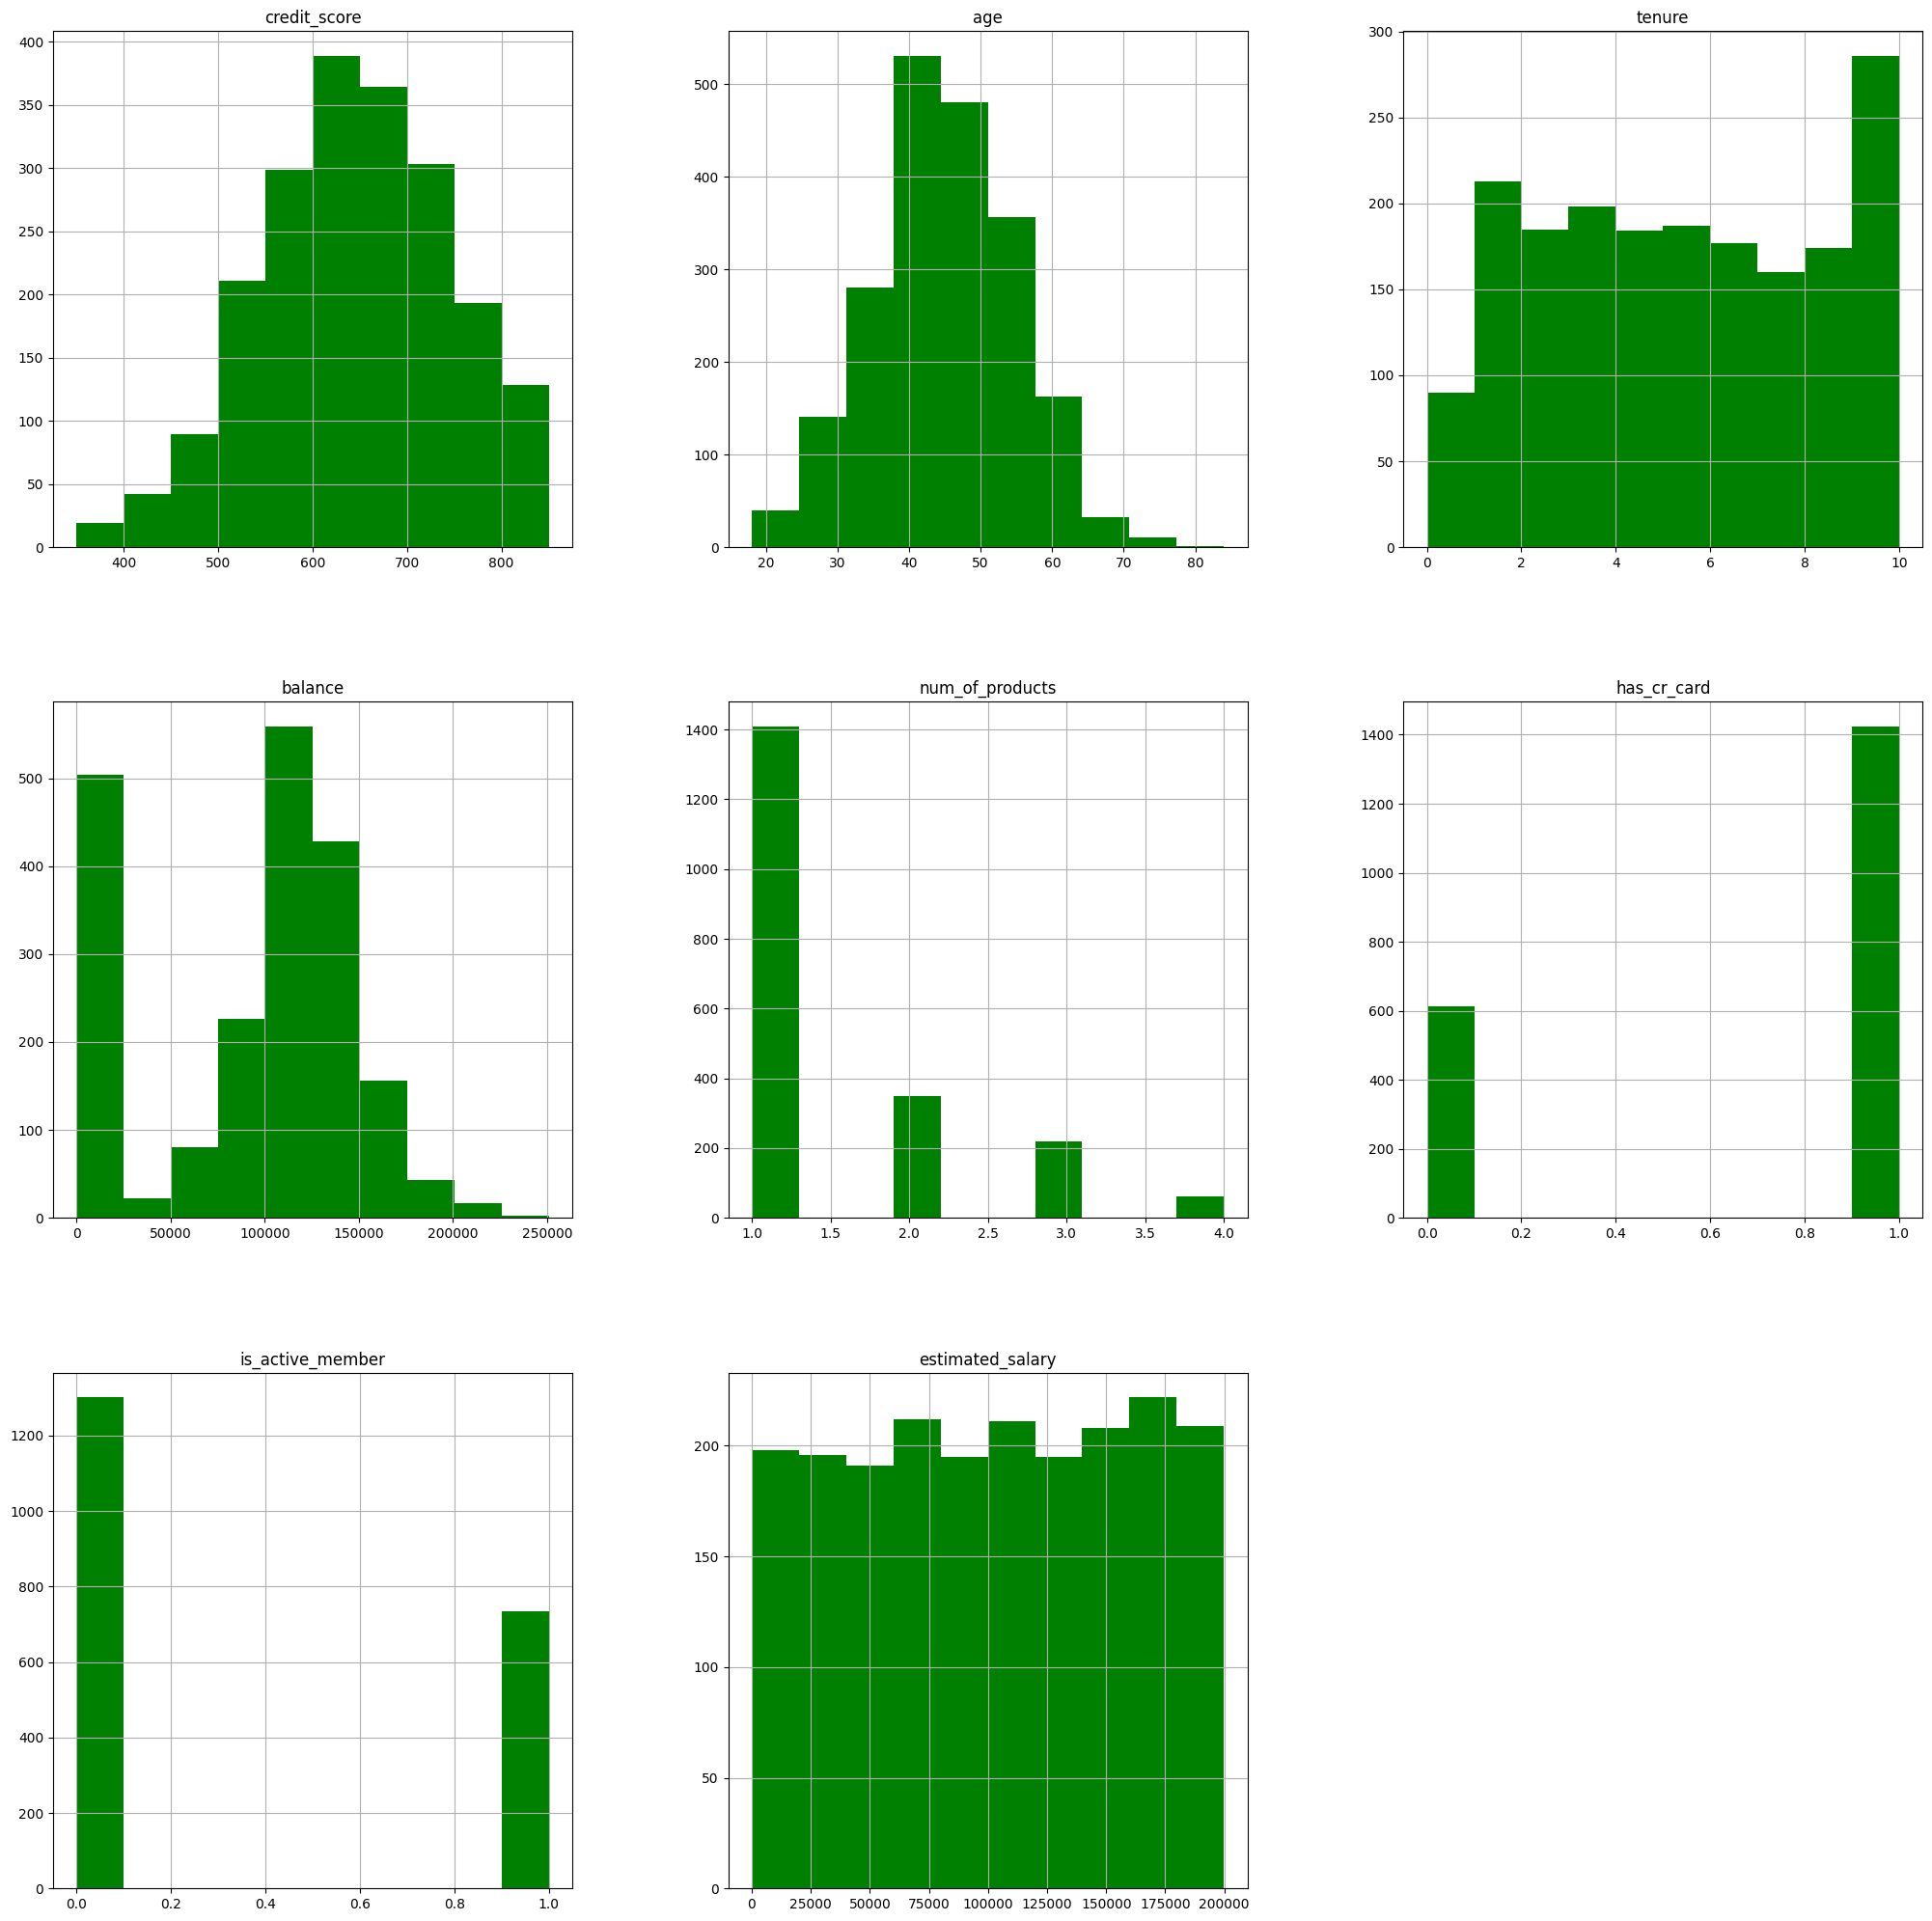

In [33]:
# Визуализация признаков среди тех, кто ушел из банка
data_stay.hist(figsize = (25,25), color = 'green');

> Рассматривая признаки по отдельности. Можно заметить, что большая часть тех, кто НЕ ушел из банка, не активна. Уходят из банка как активные, так и неактивные пользовтаели.

> Те, кто ушел из банка, больше воспользовались (как минимум) вторым продуктом продуктом банка

## Исследование баланса классов, обучение модели без учёта дисбаланса

exited
Ушел из банка       0.7963
Не ушел из банка    0.2037
Name: proportion, dtype: float64


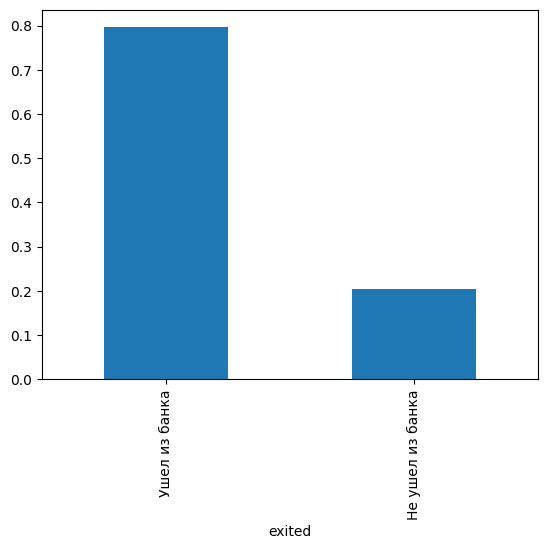

In [34]:
print(class_data)
class_data.plot(kind='bar');

> Наблюдается серьезный дисбаланс классов

Для обучения модели разделим датасет на **3 выборки** 

**Обучить модель** - подобрать тот алгоритм обучения, который больше всего подойдет обучающей выборке.

Если построить модель зависимости и оценить ее качество по одной и той же обучающей выборке, то такую модель можно перееобучить.  Высокую оценку качества построенной модели даёт её проверка на независимых данных, которые не использовались для обучения. Для этого поделим исходные данные на 3 выборки.

**Обучающая выборка** - выборка, по которой будет настраиваться модель.

**Тестовая выборка** - выборка, по которой оценивается качество (accuracy) построенной модели. Для того, чтобы модель не переобучить, тестовая и обучающая выборки должны быть независимыми.

*Для того, чтобы выбрать наилучшую модель, нужно провести оценку качества. Если мы это сделаем на тестовой выборке, то снова переобучим модель. Поэтому для этого нужно выделить третью выборку: валидационную*

**Валидационная выборка** - выборка, по которой осуществляется выбор наилучшей модели из множества моделей, построенных по обучающей выборке.

Делить выборки будем в соотношении 3:1:1 (train: valid:test).

Для начала разделим датасет на обучающую и тестовую выборки в соотношении 3:2 

In [35]:
features = data.drop(['exited'], axis=1)

target = data['exited']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size=0.4, 
                                                    random_state=12345,
                                                    stratify=target)

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [4778 1222]
Количество строк в target_test по классам: [3185  815]


А теперь разделим тестовую выборку пополам. Получим валидационную выборку. Таким образом весь наш датасет разделится в соотношении 3:1:1 

In [36]:
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, 
                                                    test_size=0.5, 
                                                    random_state=12345,
                                                    stratify= target_test)

print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")

Количество строк в target_test по классам: [1592  408]
Количество строк в target_valid по классам: [1593  407]


In [37]:
# Преобразуем техникой OHE категоральные признаки
cat_features = ['geography', 'gender'] # здесь хранится список(list) столбцов, которые нужно закодировать

features_train_categories = features_train[cat_features]
features_test_categories = features_test [cat_features]
features_valid_categories = features_valid[cat_features]

encoder = OneHotEncoder(drop='first')

ohe_features_train = encoder.fit_transform(features_train_categories).toarray() # здесь получаем новые данные в виде numpy массива
ohe_features_test = encoder.transform(features_test_categories).toarray()
ohe_features_valid  = encoder.transform(features_valid_categories).toarray()


encoded_columns = list(encoder.get_feature_names_out()) # здесь получаем список новых столбцов

features_train_categories_new = pd.DataFrame(data= ohe_features_train, 
                                             columns= encoded_columns,
                                             index= features_train_categories.index)

features_test_categories_new = pd.DataFrame(data= ohe_features_test, 
                                            columns= encoded_columns, 
                                            index= features_test_categories.index)   

features_valid_categories_new = pd.DataFrame(data= ohe_features_valid, 
                                             columns= encoded_columns,
                                             index= features_valid_categories.index)


features_train_ohe = pd.concat([features_train, features_train_categories_new], axis=1)
features_test_ohe = pd.concat([features_test, features_test_categories_new], axis=1)
features_valid_ohe = pd.concat([features_valid, features_valid_categories_new], axis=1)

In [38]:
features_train = features_train_ohe
features_test = features_test_ohe
features_valid = features_valid_ohe

In [39]:
features_train = features_train.drop(['geography', 'gender'], axis = 1)
features_test = features_test.drop(['geography', 'gender'], axis = 1)
features_valid = features_valid.drop(['geography', 'gender'], axis = 1)

In [40]:
#features_train = pd.get_dummies(features_train, columns = ['geography', 'gender'], drop_first = True)
#features_test = pd.get_dummies(features_test, columns = ['geography', 'gender'], drop_first = True)
#features_valid = pd.get_dummies(features_valid, columns = ['geography', 'gender'], drop_first = True)

In [41]:
# Промасштабируем признаки
scaler = StandardScaler()

scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
features_valid = scaler.transform(features_valid)

## 1. Решающее дерево

*Для решающего дерева важным гиперпараметром при обучении модели является max_depth - максимальная глубина. Нужно выбрать оптимальную глубину. Обычно, считается, что при глубине <4 модель недообучится. А при глубине >4 уже переобучится*

In [42]:
best_model_tree=None # принято указывать None
best_result_tree = 0 

f1_tree_valid = []
f1_tree_train =[]
depth_plot =[]

for depth in range(1,30):
    # обучение модели с заданной глубиной дерева
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    
    # обучение модели на обучающей выборке с помощью метода fit()
    model_tree.fit(features_train, target_train)
    
    
    # получение предсказания на валидационной выборке
    predictions_valid_tree = model_tree.predict(features_valid)
    predictions_train_tree = model_tree.predict(features_train)
    
    # измерение качества модели на валидационной выборке
    result_tree= f1_score(target_valid, predictions_valid_tree)
    result_tree_train = f1_score(target_train, predictions_train_tree)
    
    f1_tree_valid.append(result_tree) # собираем значения f1 для модели на valid
    f1_tree_train.append(result_tree_train) # собираем значения f1 for model on train
    depth_plot.append(depth) # список со значением глубины
 
    if result_tree> best_result_tree:
        best_model_tree = model_tree # сохраняем наилучшую модель
        best_result_tree = result_tree # сохраняем наилучшее значение метрики f1
        
print('f1 наилучшей модели на валидационной выборке:', best_result_tree)
print('Глубина наилучшей модели:', best_model_tree)

f1 наилучшей модели на валидационной выборке: 0.5517241379310345
Глубина наилучшей модели: DecisionTreeClassifier(max_depth=7, random_state=12345)


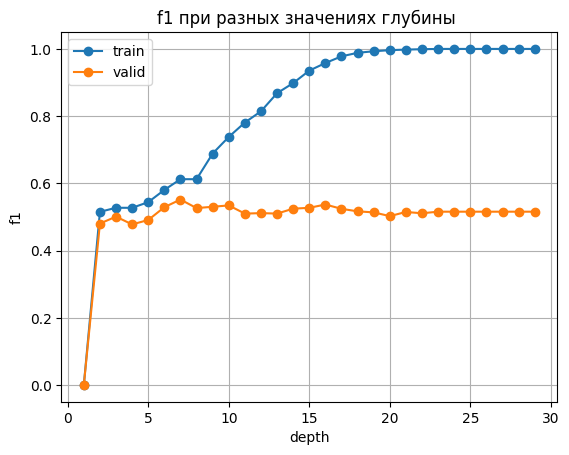

In [43]:
valid = pd.Series(f1_tree_valid)
train = pd.Series(f1_tree_train)
depth = pd.Series(depth_plot)

valid_df = valid.to_frame (name='valid')
train_df = train.to_frame (name='train')
depth_df = depth.to_frame (name='depth')

#concatenate three Series into one DataFrame
df_plot = pd.concat([valid_df, train_df, depth_df], axis= 1 )


df_plot.pivot_table(index= 'depth', values =['valid', 'train']).plot(marker ='o')
plt.title('f1 при разных значениях глубины ')
plt.ylabel('f1')
plt.xlabel('depth')
plt.grid(True)
plt.show()

> на графике видно следующее:
>* f1 for valid сначала возрастает, затем уменьшается при увеличении глубины дерева
>* f1 for train возрастает, а потом вовсе становится const

> Вывод: 
>1. f1 for valid наилучшая до max_depth=7
>2. f1 на трейне бессмысленно проверять, модель эти значения запомнила
>3. Видно, что произошло переобучение: модель хорошо объясняет примеры из обучающей выборке, но относительно плохо работает на валидации

In [44]:
probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)

In [45]:
print('f1 для наилучшей модели решающего дерева:', best_result_tree)
print('ROC-AUC для наилучшей модели решающего дерева:',auc_roc_tree)
print('recall для наилучшей модели решающего дерева:', recall_score(target_valid, predictions_valid_tree))
print('precision для наилучшей модели решающего дерева:', precision_score(target_valid, predictions_valid_tree))
print('accuracy для наилучшей модели решающего дерева', accuracy_score(target_valid, predictions_valid_tree))

f1 для наилучшей модели решающего дерева: 0.5517241379310345
ROC-AUC для наилучшей модели решающего дерева: 0.6975866467391891
recall для наилучшей модели решающего дерева: 0.5282555282555282
precision для наилучшей модели решающего дерева: 0.5035128805620609
accuracy для наилучшей модели решающего дерева 0.798


In [46]:
# Матрица предсказаний
confusion_matrix(target_valid, predictions_valid_tree)

array([[1381,  212],
       [ 192,  215]], dtype=int64)

> Модель решающего дерева негативит :) (ну, конечно, у нас же дисбаланс)

> Полоижтельные классы ей трудно предсказывать

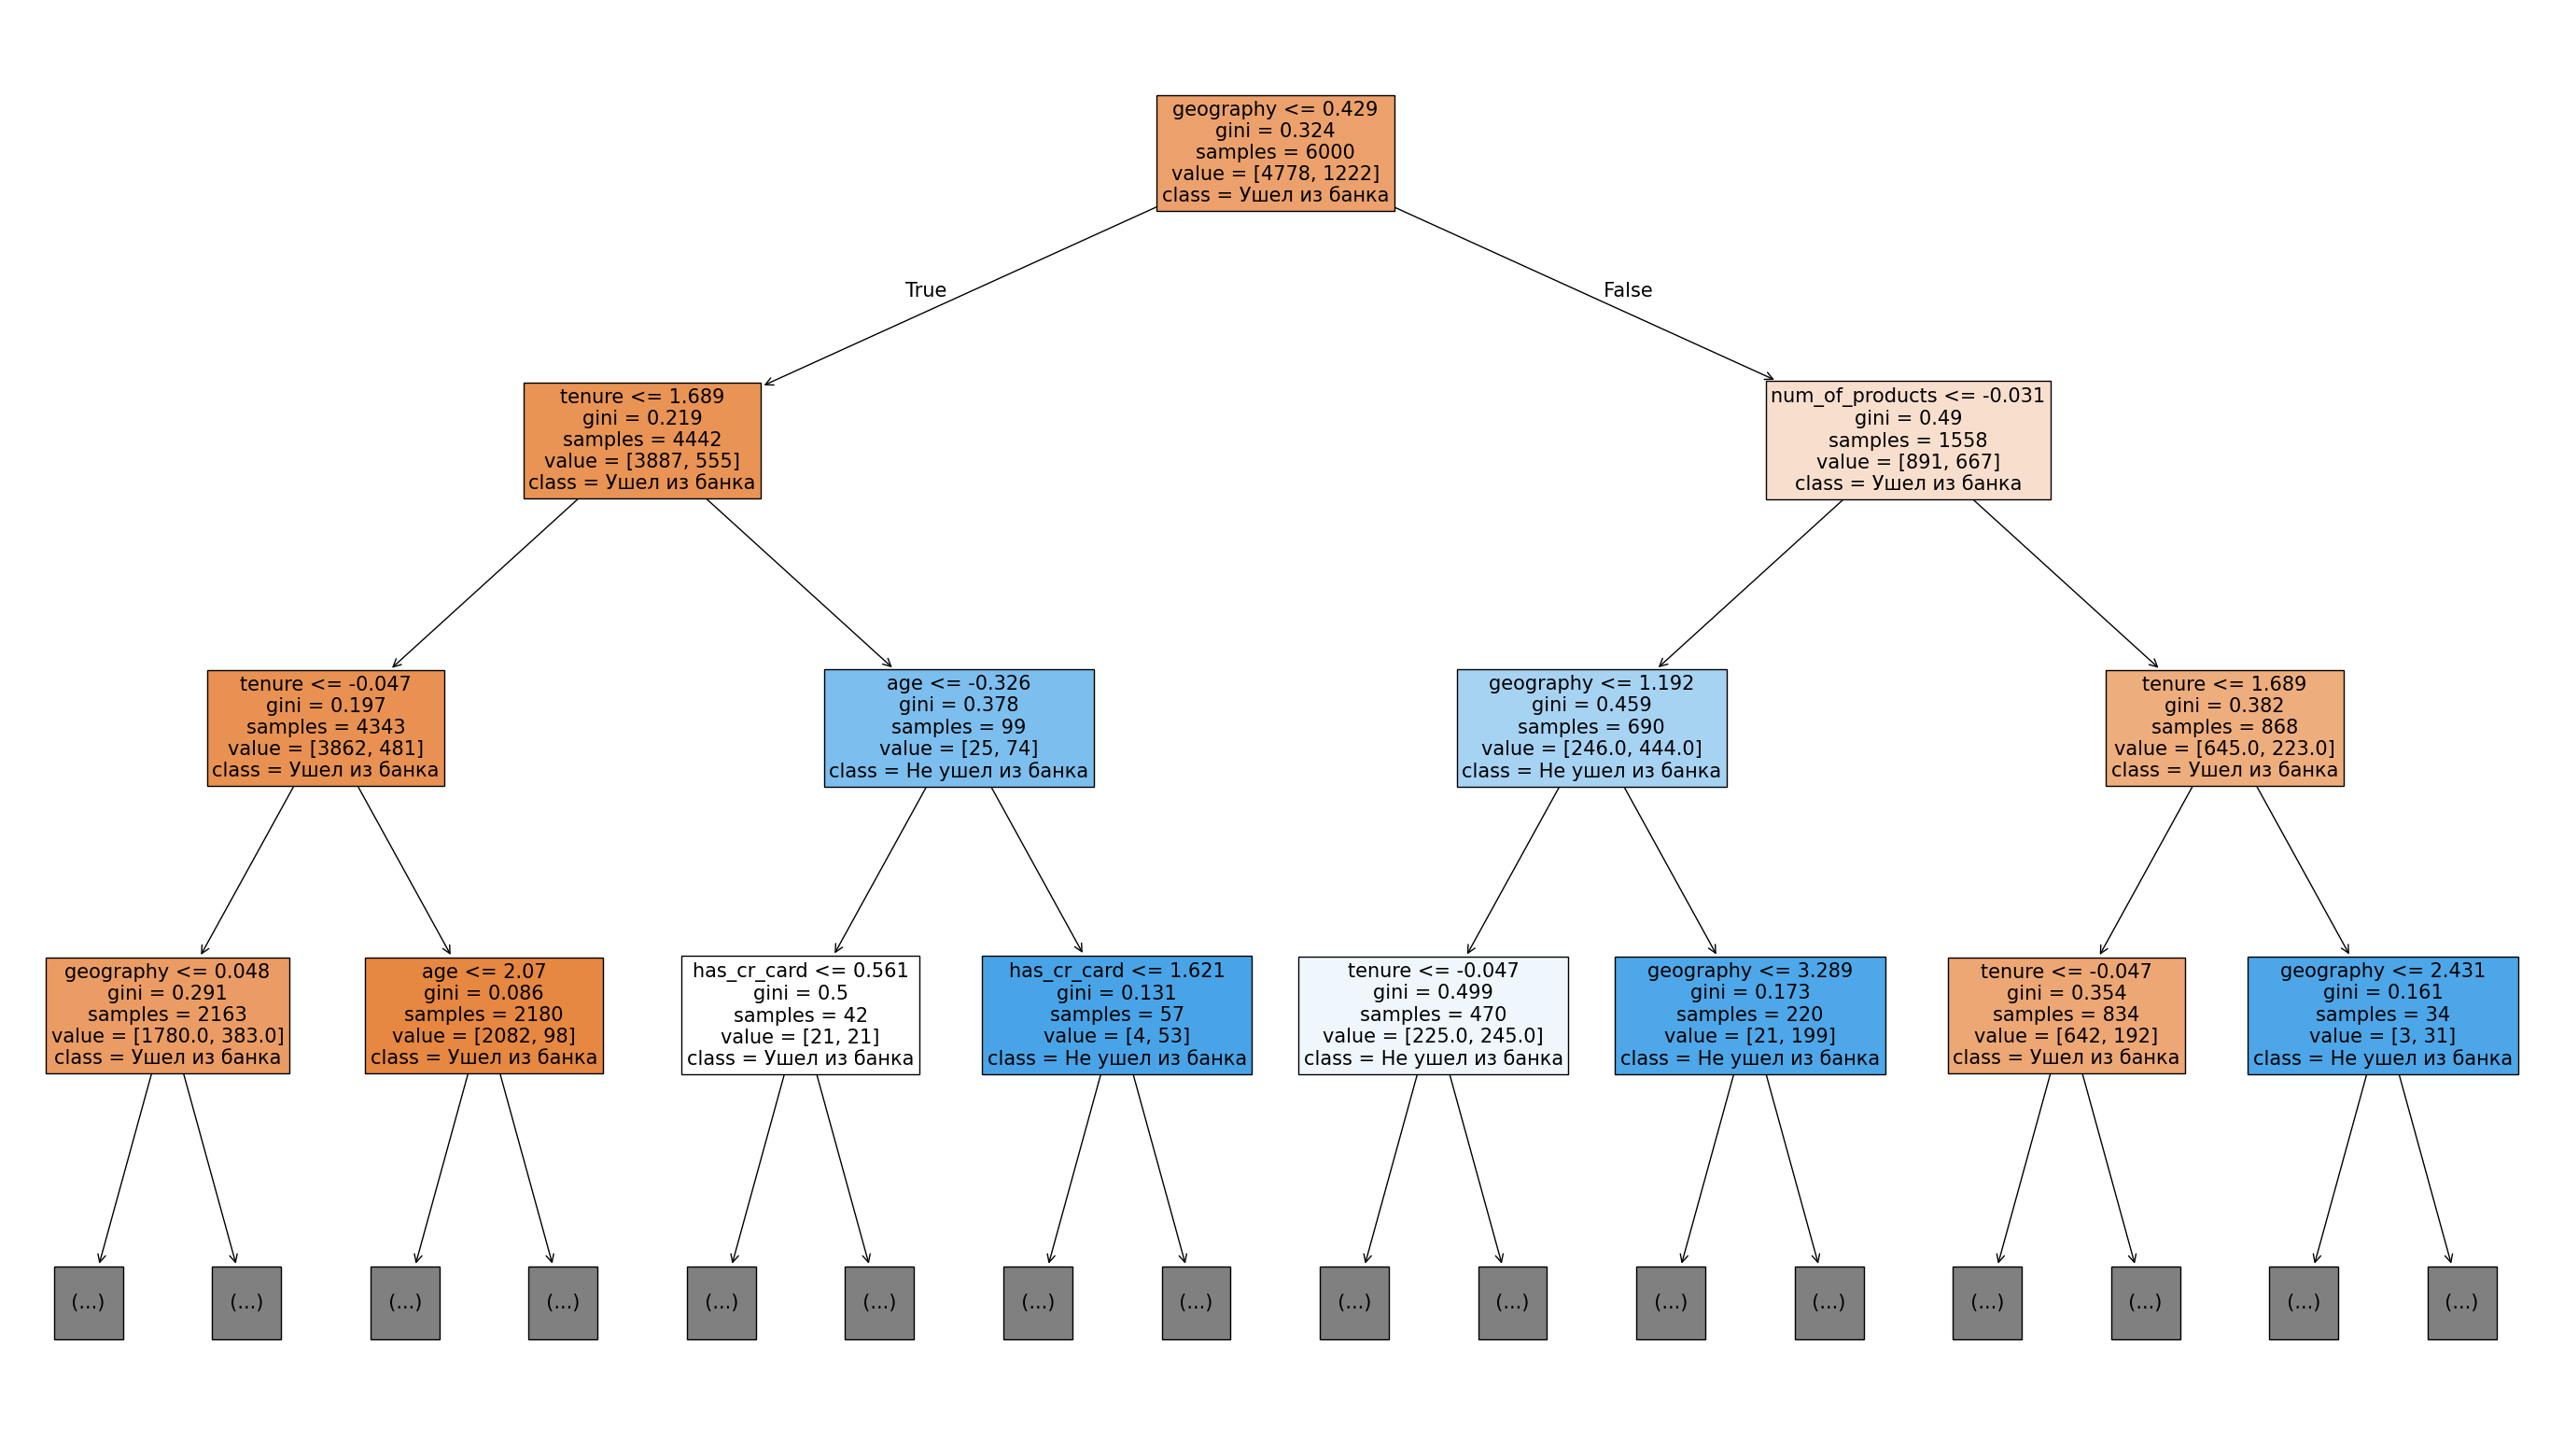

In [47]:
fig = plt.figure(figsize=(35,20))
good_tree= tree.plot_tree(best_model_tree, 
                   feature_names=features.columns.values, 
                   class_names=['Ушел из банка','Не ушел из банка'],
                   filled=True,
                   fontsize = 15,
                   max_depth = 3   
                      )
good_tree;

## 2. Случайный лес

*Для случайного леса важным гиперпараметром является количество деревьев: n_estimators*

In [48]:
best_model_forest=None # принято указывать None
best_result_forest = 0


for est in tqdm(range(1, 32), desc='💤 '):
    for depth in range(1, 15):
            
        # обучение модели с заданным количеством деревьев
        model_forest = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth = depth)
    
        # обучение модели на обучающей выборке с помощью метода fit()
        model_forest.fit(features_train, target_train)

        # получение предсказания на валидационной выборке
        predictions_valid_forest= model_forest.predict(features_valid)
    
        # измерение качества модели на валидационной выборке
        result_forest= f1_score(target_valid, predictions_valid_forest) 
    
        if result_forest> best_result_forest:
            best_model_forest = model_forest # сохраняем наилучшую модель
            best_result_forest = result_forest # сохраняем наилучшее значение метрики
        
print('f1 наилучшей модели на валидационной выборке:', best_result_forest)
print('Количество деревьев и глубина наилучшей модели:', best_model_forest)

💤 :   0%|          | 0/31 [00:00<?, ?it/s]

💤 : 100%|██████████| 31/31 [01:27<00:00,  2.81s/it]

f1 наилучшей модели на валидационной выборке: 0.5651537335285505
Количество деревьев и глубина наилучшей модели: RandomForestClassifier(max_depth=13, n_estimators=9, random_state=12345)


In [49]:
probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)

In [50]:
print('f1 для наилучшей модели случайного леса:', best_result_forest)
print('ROC-AUC для наилучшей модели случайного леса:',auc_roc_forest)
print('recall для наилучшей модели случайного леса:', recall_score(target_valid, predictions_valid_forest))
print('precision для наилучшей модели случайного леса:', precision_score(target_valid, predictions_valid_forest))
print('accuracy для наилучшей модели случайного леса', accuracy_score(target_valid, predictions_valid_forest))

f1 для наилучшей модели случайного леса: 0.5651537335285505
ROC-AUC для наилучшей модели случайного леса: 0.8440620898248017
recall для наилучшей модели случайного леса: 0.42997542997543
precision для наилучшей модели случайного леса: 0.7056451612903226
accuracy для наилучшей модели случайного леса 0.8475


In [51]:
# Матрица предсказаний
confusion_matrix(target_valid, predictions_valid_forest)

array([[1520,   73],
       [ 232,  175]], dtype=int64)

**3) Логистическая регрессия**

In [52]:
model_logistic = LogisticRegression(random_state=12345, solver = 'lbfgs', max_iter = 10000)

#обучение модели на обучающей выборке с помощью метода fit()
model_logistic.fit(features_train, target_train)

# получение предсказания на валидационной выборке
predictions_valid_logistic = model_logistic.predict(features_valid)
    
# измерение качества модели на валидационной выборке
result_logistic= f1_score(target_valid, predictions_valid_logistic)


print('f1 модели логистической регрессии:', result_logistic)

f1 модели логистической регрессии: 0.2932330827067669


> ROC-кривая (кривая ошибок)- кривая перебора значения порога логистической регрессии

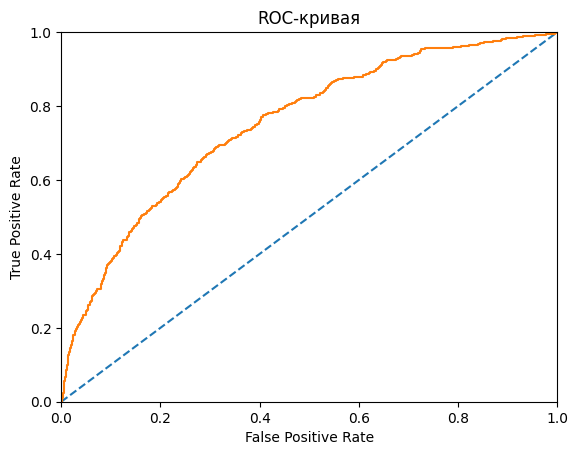

In [53]:
probabilities_valid_logistic = model_logistic.predict_proba(features_valid)
probabilities_one_valid_logistic = probabilities_valid_logistic[:, 1]

auc_roc_logistic = roc_auc_score(target_valid, probabilities_one_valid_logistic)

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid_logistic)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_logistic)
plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
plt.ylim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

In [54]:
print('f1 для наилучшей модели логистической регрессии:', result_logistic)
print('ROC-AUC для наилучшей модели логистической регрессии:',auc_roc_logistic)
print('recall для наилучшей модели логистической регрессии:', recall_score(target_valid, predictions_valid_logistic))
print('precision для наилучшей модели логистической регрессии:', precision_score(target_valid, predictions_valid_logistic))
print('accuracy для наилучшей модели логистической регрессии', accuracy_score(target_valid, predictions_valid_logistic))

f1 для наилучшей модели логистической регрессии: 0.2932330827067669
ROC-AUC для наилучшей модели логистической регрессии: 0.7505486997012419
recall для наилучшей модели логистической регрессии: 0.19164619164619165
precision для наилучшей модели логистической регрессии: 0.624
accuracy для наилучшей модели логистической регрессии 0.812


> Чем ближе ROC-AUC к 1 тем:
> * выше график
> * больше значения TPR 
> * лучше качество модели

## Улучшение качества модели, учитывая дисбаланс классов. Обучение разных моделей и поиск лучшей

Чтобы сделать объекты редкого класса не такими редкими, нужно применить технику upsampling

Чтобы сделать объекты частого класса не такими частыми, нужно применить технику downsampling

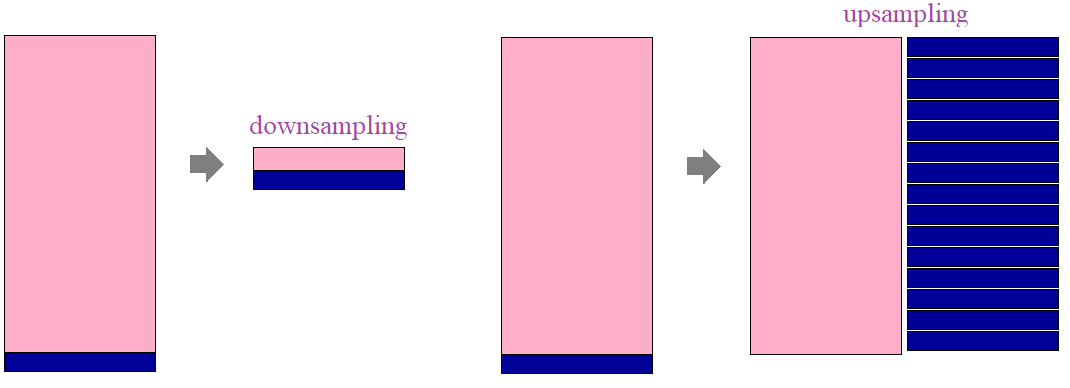

---

**Upsampling**

---

In [55]:
class_data

exited
Ушел из банка       0.7963
Не ушел из банка    0.2037
Name: proportion, dtype: float64

>  Отрицательного класса в 4 раза меньше

In [56]:
features_train = pd.DataFrame(features_train).reset_index(drop=True)
features_valid = pd.DataFrame(features_valid).reset_index(drop=True)

target_train = pd.Series(target_train).reset_index(drop=True)
target_valid = pd.Series(target_valid).reset_index(drop=True)


features_test = pd.DataFrame(features_test).reset_index(drop=True)
target_test = pd.Series(target_test).reset_index(drop=True)

In [57]:
def upsample(features, target, repeate):
    
    # Разделим  sampling на negative and positive объекты для downsampling and upsampling
    features_zeros_train = features_train[target_train==0]
    features_ones_train = features_train[target_train == 1]
    target_zeros_train = target_train[target_train==0]
    target_ones_train = target_train[target_train ==1]
    
    # Увеличиваем отрицательный класс и склеиваем их с положительным классом
    features_upsampled_train = pd.concat([features_zeros_train]*repeate + [features_ones_train])
    target_upsampled_train= pd.concat ([target_zeros_train]*repeate + [target_ones_train])
    

    # Миксуем данные
    features_upsampled_train, target_upsampled_train = shuffle(features_upsampled_train, target_upsampled_train, random_state = 12345)
    
    return features_upsampled_train, target_upsampled_train

features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4)

In [58]:
#from imblearn.under_sampling import RandomUnderSampler 
#rus = RandomUnderSampler() 
#X_resampled, y_resampled = rus.fit_sample(features_train, target_train) 

**1) Решающее дерево после upsampling**

In [59]:
best_model_tree_up=None # принято указывать None
best_result_tree_up = 0 

f1_tree_valid_up = []
f1_tree_train_up =[]
depth_plot_up =[]

for depth in range(1,30):
    # обучение модели с заданной глубиной дерева
    model_tree_up = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    
    # обучение модели на обучающей выборке с помощью метода fit()
    model_tree_up.fit(features_upsampled_train, target_upsampled_train)

    # получение предсказания на валидационной выборке
    predictions_valid_tree_up = model_tree_up.predict(features_valid)
    predictions_train_tree_up = model_tree_up.predict(features_upsampled_train)
    
    # измерение качества модели на валидационной выборке
    result_tree_up= f1_score(target_valid, predictions_valid_tree_up)
    result_tree_train_up = f1_score(target_upsampled_train, predictions_train_tree_up)
    
    f1_tree_valid_up.append(result_tree_up) # собираем значения f1 для модели на valid
    f1_tree_train_up.append(result_tree_train_up) # собираем значения f1 for model on train
    depth_plot_up.append(depth) # список со значением глубины
    
    if result_tree_up> best_result_tree_up:
        best_model_tree_up = model_tree_up # сохраняем наилучшую модель
        best_result_tree_up = result_tree_up # сохраняем наилучшее значение метрики f1
        
print('f1 наилучшей модели на валидационной выборке:', best_result_tree_up)
print('Глубина наилучшей модели:', best_model_tree_up)

f1 наилучшей модели на валидационной выборке: 0.5216374269005848
Глубина наилучшей модели: DecisionTreeClassifier(max_depth=22, random_state=12345)


In [60]:
probabilities_valid_tree_up = model_tree_up.predict_proba(features_valid)
probabilities_one_valid_tree_up = probabilities_valid_tree_up[:, 1]

auc_roc_tree_up = roc_auc_score(target_valid, probabilities_one_valid_tree_up)

In [61]:
print('f1 для наилучшей модели решающего дерева после upsampling:', best_result_tree_up)
print('ROC-AUC для наилучшей модели решающего дерева после upsampling:',auc_roc_tree_up)
print('recall для наилучшей модели решающего дерева после upsampling:', recall_score(target_valid, predictions_valid_tree_up))
print('precision для наилучшей модели решающего дерева после upsampling:', precision_score(target_valid, predictions_valid_tree_up))
print('accuracy для наилучшей модели решающего дерева после upsampling:', accuracy_score(target_valid, predictions_valid_tree_up))

f1 для наилучшей модели решающего дерева после upsampling: 0.5216374269005848
ROC-AUC для наилучшей модели решающего дерева после upsampling: 0.6925916671679384
recall для наилучшей модели решающего дерева после upsampling: 0.5257985257985258
precision для наилучшей модели решающего дерева после upsampling: 0.4885844748858447
accuracy для наилучшей модели решающего дерева после upsampling: 0.7915


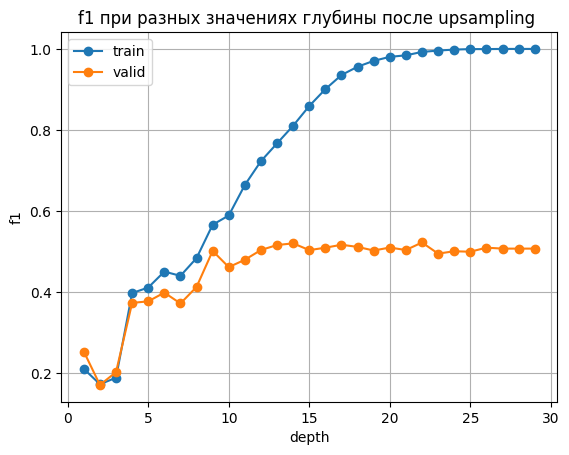

In [62]:
valid_up = pd.Series(f1_tree_valid_up)
train_up = pd.Series(f1_tree_train_up)
depth_up = pd.Series(depth_plot_up)

valid_df_up = valid_up.to_frame (name='valid')
train_df_up = train_up.to_frame (name='train')
depth_df_up = depth_up.to_frame (name='depth')

#concatenate three Series into one DataFrame
df_plot_up = pd.concat([valid_df_up, train_df_up, depth_df_up], axis= 1 )


df_plot_up.pivot_table(index= 'depth', values =['valid', 'train']).plot(marker ='o')
plt.title('f1 при разных значениях глубины после upsampling ')
plt.ylabel('f1')
plt.xlabel('depth')
plt.grid(True)
plt.show()

> До upsampling f1 наилучшей модели с глубиной  max_depth=7  составляла : 0.5517

>Upsampling не помог, а только ухудшил показание метрики

**2) Случайный лес после upsampling**

In [63]:
best_model_forest_up=None # принято указывать None
best_result_forest_up = 0


for est in tqdm(range(1, 32), desc='💤 '):
    for depth in range(1, 15):
            
        # обучение модели с заданным количеством деревьев
        model_forest_up = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth = depth)
    
        # обучение модели на обучающей выборке с помощью метода fit()
        model_forest_up.fit(features_upsampled_train, target_upsampled_train)

        # получение предсказания на валидационной выборке
        predictions_valid_forest_up= model_forest_up.predict(features_valid)
    
        # измерение качества модели на валидационной выборке
        result_forest_up= f1_score(target_valid, predictions_valid_forest_up) 
    
        if result_forest_up> best_result_forest_up:
            best_model_forest_up = model_forest_up # сохраняем наилучшую модель
            best_result_forest_up = result_forest_up # сохраняем наилучшее значение метрики f1
        
print('f1 наилучшей модели на валидационной выборке:', best_result_forest_up)
print('Количество деревьев и глубина наилучшей модели:', best_model_forest_up)

💤 : 100%|██████████| 31/31 [02:25<00:00,  4.69s/it]

f1 наилучшей модели на валидационной выборке: 0.4897959183673469
Количество деревьев и глубина наилучшей модели: RandomForestClassifier(max_depth=14, n_estimators=20, random_state=12345)


> Модели случайного леса тоже не пошлел на пользу upsamplig

> До сэмплированя  f1 наилучшей модели (max_depth=13, n_estimators=9,) на валидационной выборке: 0.5652

In [64]:
probabilities_valid_forest_up = model_forest_up.predict_proba(features_valid)
probabilities_one_valid_forest_up = probabilities_valid_forest_up[:, 1]

auc_roc_forest_up = roc_auc_score(target_valid, probabilities_one_valid_forest_up)

In [65]:
print('f1 для наилучшей модели случайного леса после upsampling:', best_result_forest_up)
print('ROC-AUC для наилучшей модели случайного леса после upsampling:',auc_roc_forest_up)
print('recall для наилучшей модели случайного леса после upsampling:', recall_score(target_valid, predictions_valid_forest_up))
print('precision для наилучшей модели случайного леса после upsampling:', precision_score(target_valid, predictions_valid_forest_up))
print('accuracy для наилучшей модели случайного леса после upsampling:', accuracy_score(target_valid, predictions_valid_forest_up))

f1 для наилучшей модели случайного леса после upsampling: 0.4897959183673469
ROC-AUC для наилучшей модели случайного леса после upsampling: 0.828867388189422
recall для наилучшей модели случайного леса после upsampling: 0.3488943488943489
precision для наилучшей модели случайного леса после upsampling: 0.7932960893854749
accuracy для наилучшей модели случайного леса после upsampling: 0.849


**3) Логистическая регрессия после upsampling**

In [66]:
model_logistic_up = LogisticRegression(random_state=12345, solver = 'lbfgs', max_iter = 10000)

#обучение модели на обучающей выборке с помощью метода fit()
model_logistic_up.fit(features_upsampled_train, target_upsampled_train)

# получение предсказания на валидационной выборке
predictions_valid_logistic_up = model_logistic_up.predict(features_valid)
    
# измерение качества модели на валидационной выборке
result_logistic_up = f1_score(target_valid, predictions_valid_logistic_up)


print('f1 модели логистической регрессии:', result_logistic_up)

f1 модели логистической регрессии: 0.014527845036319613


> До сэмлирования f1 модели логистической регрессии была 0.2932. Upsampling не пошел на пользу

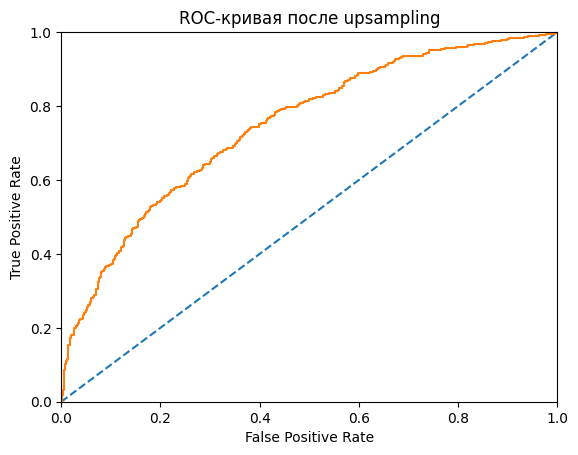

In [67]:
probabilities_valid_logistic_up = model_logistic_up.predict_proba(features_valid)
probabilities_one_valid_logistic_up = probabilities_valid_logistic_up[:, 1]

auc_roc_logistic_up = roc_auc_score(target_valid, probabilities_one_valid_logistic_up)

precision_up, recall_up, thresholds_up = precision_recall_curve(target_valid, probabilities_one_valid_logistic_up)
fpr_up, tpr_up, thresholds_up = roc_curve(target_valid, probabilities_one_valid_logistic_up)
plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_up,tpr_up)
plt.xlim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
plt.ylim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая после upsampling')

plt.show()

In [68]:
print('f1 для наилучшей модели логистической регрессии после upsampling:', result_logistic_up)
print('ROC-AUC для наилучшей модели рлогистической регрессии после upsampling:',auc_roc_logistic_up)
print('recall для наилучшей модели логистической регрессии после upsampling:', recall_score(target_valid, predictions_valid_logistic_up))
print('precision для наилучшей модели логистической регрессии после upsampling:', precision_score(target_valid, predictions_valid_logistic_up))
print('accuracy для наилучшей модели логистической регрессии после upsampling:', accuracy_score(target_valid, predictions_valid_logistic_up))

f1 для наилучшей модели логистической регрессии после upsampling: 0.014527845036319613
ROC-AUC для наилучшей модели рлогистической регрессии после upsampling: 0.7459447120464071
recall для наилучшей модели логистической регрессии после upsampling: 0.007371007371007371
precision для наилучшей модели логистической регрессии после upsampling: 0.5
accuracy для наилучшей модели логистической регрессии после upsampling: 0.7965


> Чем ближе ROC-AUC к 1 тем:
> * выше график
> * больше значения TPR 
> * лучше качество модели

---

**Downsampling**

---

In [69]:
def downsample(features, target, fraction):
    
    # Разделим train sampling на negative and positive объекты для downsampling and upsampling
    features_zeros_train = features_train[target_train==0]
    features_ones_train = features_train[target_train == 1]
    target_zeros_train = target_train[target_train==0]
    target_ones_train = target_train[target_train ==1]
    
    # Случайным образом отбросим часть из отрицательных объектов
    features_downsampled_train = pd.concat([features_zeros_train.sample(frac=fraction, random_state=12345)] + [features_ones_train])
    target_downsampled_train= pd.concat ([target_zeros_train.sample(frac=fraction, random_state=12345)] + [target_ones_train])
    

    # Миксуем данные
    features_downsampled_train, target_downsampled_train = shuffle(features_downsampled_train, target_downsampled_train, random_state = 12345)
    
    return features_downsampled_train, target_downsampled_train

features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.4)


**1) Решающее дерево после downsampling**

In [70]:
best_model_tree_down=None # принято указывать None
best_result_tree_down = 0 

f1_tree_valid_down = []
f1_tree_train_down =[]
depth_plot_down =[]

for depth in range(1,30):
    # обучение модели с заданной глубиной дерева
    model_tree_down = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    
    # обучение модели на обучающей выборке с помощью метода fit()
    model_tree_down.fit(features_downsampled_train, target_downsampled_train)

    # получение предсказания на валидационной выборке
    predictions_valid_tree_down = model_tree_down.predict(features_valid)
    predictions_train_tree_down = model_tree_down.predict(features_downsampled_train)
    
    # измерение качества модели на валидационной выборке
    result_tree_down = f1_score(target_valid, predictions_valid_tree_down)
    result_tree_train_down = f1_score(target_downsampled_train, predictions_train_tree_down)
    
    f1_tree_valid_down.append(result_tree_down) # собираем значения f1 для модели на valid
    f1_tree_train_down.append(result_tree_train_down) # собираем значения f1 for model on train
    depth_plot_down.append(depth) # список со значением глубины
    
    if result_tree_down> best_result_tree_down:
        best_model_tree_down = model_tree_down # сохраняем наилучшую модель
        best_result_tree_down = result_tree_down # сохраняем наилучшее значение метрики f1
        
print('f1 наилучшей модели на валидационной выборке:', best_result_tree_down)
print('Глубина наилучшей модели:', best_model_tree_down)

f1 наилучшей модели на валидационной выборке: 0.5737327188940092
Глубина наилучшей модели: DecisionTreeClassifier(max_depth=5, random_state=12345)


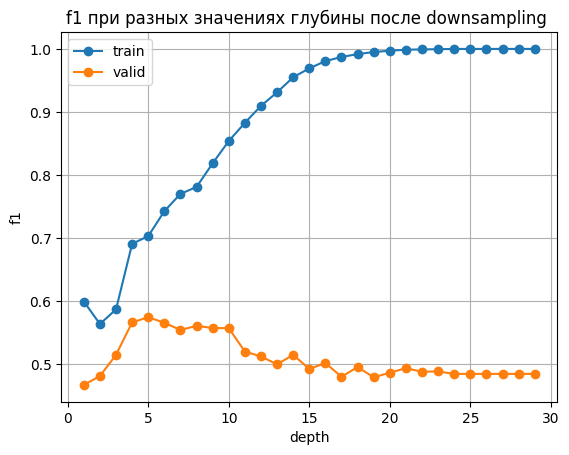

In [71]:
valid_down = pd.Series(f1_tree_valid_down)
train_down = pd.Series(f1_tree_train_down)
depth_down = pd.Series(depth_plot_down)

valid_df_down = valid_down.to_frame (name='valid')
train_df_down = train_down.to_frame (name='train')
depth_df_down = depth_down.to_frame (name='depth')

#concatenate three Series into one DataFrame
df_plot_down = pd.concat([valid_df_down, train_df_down, depth_df_down], axis= 1 )


df_plot_down.pivot_table(index= 'depth', values =['valid', 'train']).plot(marker ='o')
plt.title('f1 при разных значениях глубины после downsampling ')
plt.ylabel('f1')
plt.xlabel('depth')
plt.grid(True)
plt.show()

In [72]:
probabilities_valid_tree_down = model_tree_down.predict_proba(features_valid)
probabilities_one_valid_tree_down = probabilities_valid_tree_down[:, 1]

auc_roc_tree_down = roc_auc_score(target_valid, 
                                      probabilities_one_valid_tree_down)

In [73]:
print('f1 для наилучшей модели решающего дерева после downsampling:', best_result_tree_down)
print('ROC-AUC для наилучшей модели рлогистической регрессии после downsampling:',auc_roc_tree_down)
print('recall для наилучшей модели решающего дерева после downsampling:', recall_score(target_valid, predictions_valid_tree_down))
print('precision для наилучшей модели решающего дерева после downsampling:', precision_score(target_valid, predictions_valid_tree_down))
print('accuracy для наилучшей модели решающего дерева после downsampling:', accuracy_score(target_valid, predictions_valid_tree_down))

f1 для наилучшей модели решающего дерева после downsampling: 0.5737327188940092
ROC-AUC для наилучшей модели рлогистической регрессии после downsampling: 0.6896557574523675
recall для наилучшей модели решающего дерева после downsampling: 0.6216216216216216
precision для наилучшей модели решающего дерева после downsampling: 0.39593114241001565
accuracy для наилучшей модели решающего дерева после downsampling: 0.73


> downsampling помог увеличить значения метрик

**2) Случайный лес после downsampling**

In [74]:
best_model_forest_down=None # принято указывать None
best_result_forest_down = 0


for est in tqdm(range(1, 32), desc='💤 '):
    for depth in range(1, 15):
            
        # обучение модели с заданным количеством деревьев
        model_forest_down = RandomForestClassifier(random_state=12345, n_estimators = est, max_depth = depth)
    
        # обучение модели на обучающей выборке с помощью метода fit()
        model_forest_down.fit(features_downsampled_train, target_downsampled_train)

        # получение предсказания на валидационной выборке
        predictions_valid_forest_down= model_forest_down.predict(features_valid)
    
        # измерение качества модели на валидационной выборке
        result_forest_down= f1_score(target_valid, predictions_valid_forest_down) 
    
        if result_forest_down> best_result_forest_down:
            best_model_forest_down = model_forest_down # сохраняем наилучшую модель
            best_result_forest_down = result_forest_down # сохраняем наилучшее значение метрики f1
        
print('f1 наилучшей модели на валидационной выборке:', best_result_forest_down)
print('Количество деревьев и глубина наилучшей модели:', best_model_forest_down)

💤 : 100%|██████████| 31/31 [00:46<00:00,  1.51s/it]

f1 наилучшей модели на валидационной выборке: 0.6137440758293838
Количество деревьев и глубина наилучшей модели: RandomForestClassifier(max_depth=6, n_estimators=24, random_state=12345)


In [75]:
probabilities_valid_forest_down = model_forest_down.predict_proba(features_valid)
probabilities_one_valid_forest_down = probabilities_valid_forest_down[:, 1]

auc_roc_forest_down = roc_auc_score(target_valid, 
                                      probabilities_one_valid_forest_down)

In [76]:
print('f1 для наилучшей модели случайного леса после downsampling:', best_result_forest_down)
print('ROC-AUC для наилучшей модели рлогистической регрессии после downsampling:',auc_roc_forest_down)
print('recall для наилучшей модели случайного леса после downsampling:', recall_score(target_valid, predictions_valid_forest_down))
print('precision для наилучшей модели случайного леса после downsampling:', precision_score(target_valid, predictions_valid_forest_down))
print('accuracy для наилучшей модели случайного леса после downsampling:', accuracy_score(target_valid, predictions_valid_forest_down))

f1 для наилучшей модели случайного леса после downsampling: 0.6137440758293838
ROC-AUC для наилучшей модели рлогистической регрессии после downsampling: 0.8371136930458966
recall для наилучшей модели случайного леса после downsampling: 0.6412776412776413
precision для наилучшей модели случайного леса после downsampling: 0.5600858369098712
accuracy для наилучшей модели случайного леса после downsampling: 0.8245


**3) Логистическая регрессия после downsampling**

In [77]:
model_logistic_down = LogisticRegression(random_state=12345, solver = 'lbfgs', max_iter = 10000)

#обучение модели на обучающей выборке с помощью метода fit()
model_logistic_down.fit(features_downsampled_train, target_downsampled_train)

# получение предсказания на валидационной выборке
predictions_valid_logistic_down = model_logistic_down.predict(features_valid)
    
# измерение качества модели на валидационной выборке
result_logistic_down = f1_score(target_valid, predictions_valid_logistic_down)


print('f1 модели логистической регрессии:', result_logistic_down)

f1 модели логистической регрессии: 0.45727482678983833


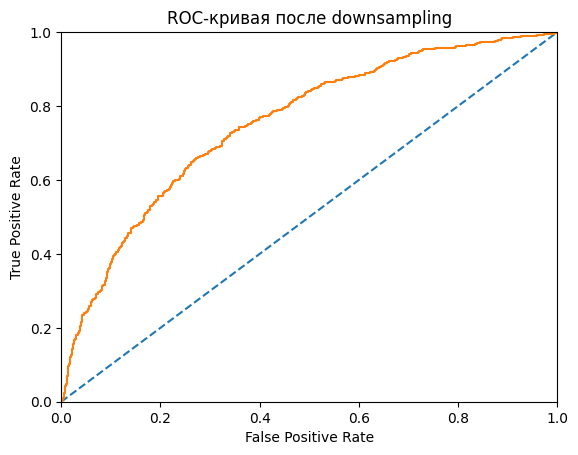

In [78]:
probabilities_valid_logistic_down = model_logistic_down.predict_proba(features_valid)
probabilities_one_valid_logistic_down = probabilities_valid_logistic_down[:, 1]

auc_roc_logistic_down = roc_auc_score(target_valid, 
                                      probabilities_one_valid_logistic_down)

precision_down, recall_down, thresholds_down = precision_recall_curve(target_valid, 
                                                                      probabilities_one_valid_logistic_down)
fpr_down, tpr_down, thresholds_down = roc_curve(target_valid, 
                                                probabilities_one_valid_logistic_down)
plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_down,tpr_down)
plt.xlim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
plt.ylim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая после downsampling')

plt.show()

In [79]:
print('f1 для наилучшей модели логистической регрессии после downsampling:', result_logistic_down)
print('ROC-AUC для наилучшей модели рлогистической регрессии после downsampling:',auc_roc_logistic_down)
print('recall для наилучшей модели логистической регрессии после downsampling:', recall_score(target_valid, predictions_valid_logistic_down))
print('precision для наилучшей модели логистической регрессии после downsampling:', precision_score(target_valid, predictions_valid_logistic_down))
print('accuracy для наилучшей модели логистической регрессии после downsampling:', accuracy_score(target_valid, predictions_valid_logistic_down))

f1 для наилучшей модели логистической регрессии после downsampling: 0.45727482678983833
ROC-AUC для наилучшей модели рлогистической регрессии после downsampling: 0.7531429734819565
recall для наилучшей модели логистической регрессии после downsampling: 0.4864864864864865
precision для наилучшей модели логистической регрессии после downsampling: 0.43137254901960786
accuracy для наилучшей модели логистической регрессии после downsampling: 0.765


> Чем ближе ROC-AUC к 1 тем:
> * выше график
> * больше значения TPR 
> * лучше качество модели

<h1>Вывод:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**1) Результаты до sampling:**
* решающее дерево:
  * f1: 0.5517
  * ROC-AUC: 0.6976
  * recall: 0.5283
  * precision: 0.504
  * accuracy: 0.798


* случаный лес:
  * f1 : 0.5652
  * ROC-AUC: 0.84401
  * recall: 0.42998
  * precision: 0.70565
  * accuracy: 0.8475


* логистическая регрессия:
  * f1: 0.2932330827067669
  * ROC-AUC: 0.7505394454546996
  * recall: 0.19164619164619165
  * precision: 0.624
  * accuracy: 0.812

  
**2) Результаты после upsampling:**
* решающее дерево

  * f1: 0.52164
  * ROC-AUC: 0.6926
  * recall: 0.5258
  * precision: 0.4886
  * accuracy: 0.7915

  
* случайный лес
  * f1: 0.4898
  * ROC-AUC: 0.8289
  * recall: 0.3489
  * precision: 0.7933
  * accuracy: 0.849



* логистическая регрессия
  * f1: 0.01453
  * ROC-AUC: 0.746
  * recall: 0.00737
  * precision: 0.5  
  * accuracy: 0.7965
  
**3) Результаты после downsampling:**
* решающее дерево
  * f1: 0.5737
  * ROC-AUC: 0.6897
  * recall: 0.6216
  * precision: 0.3959
  * accuracy: 0.73


* случаный лес
  * f1: 0.6137440758293838
  * ROC-AUC: 0.8371136930458966
  * recall: 0.6412776412776413
  * precision: 0.5600858369098712
  * accuracy: 0.8245



* логистическая регрессия
  * f1: 0.4572748267898384
  * ROC-AUC: 0.7531414311075327
  * recall: 0.4864864864864865
  * precision: 0.43137254901960786
  * accuracy: 0.765


*Стоит отметить, что на меру f1 влияет полнота и точность. Когда полнота или точность близки к 0, то F1 тоже приближается к 0*
**Upsampling вовсе не удался. Но после downsampling метрики у всех моделей выросли**

*Видно, что метрика accuracy подводит(из-за своих расчетов). Будем судить по метрике f1.*

**Лучшей моделью оказался случаный лес после downsampling c f1~ 0.614. Осталось провести для него финальное тестирование**


## Финальное тестирование

In [80]:
# Проверка наилучшей модели случайного леса на test
model_forest_down = RandomForestClassifier(max_depth=9, n_estimators=14, random_state=12345)

#обучение на обучащей выборке
model_forest_down.fit(features_train, target_train)

predictions_good_forest = model_forest_down.predict(features_test)

print("Наилучшая модель: случайный лес")
print('f1 на тестовой выборке:', f1_score(target_test, predictions_good_forest))
print('recall на тестовой выборке:', recall_score(target_test, predictions_good_forest))
print('precision на тестовой выборке:', precision_score(target_test, predictions_good_forest))
print('accuracy на тестовой выборке:', accuracy_score(target_test, predictions_good_forest))

Наилучшая модель: случайный лес
f1 на тестовой выборке: 0.599388379204893
recall на тестовой выборке: 0.4803921568627451
precision на тестовой выборке: 0.7967479674796748
accuracy на тестовой выборке: 0.869


> на valid
>* f1: 0.6137440758293838
>* ROC-AUC: 0.8371136930458966
>* recall: 0.6412776412776413
>* precision: 0.5600858369098712
>* accuracy: 0.8245

*При проверке на тестовой выборке лучшей модели уменьшилась полнота, но увеличилась точность. Поэтому f1 тоже поменялась. Модель прошла проверку на тестовой выборке*

**Проверка модели на вменяемость**

Тестовая выборка- имитация реальных данных

In [81]:
model_dummy = DummyClassifier(strategy='prior')
model_dummy.fit(features_downsampled_train, target_downsampled_train)
predict_dummy = model_dummy.predict(features_test)
print('f1 :', f1_score(target_test, predict_dummy ))
print('recall :', recall_score(target_test, predict_dummy))
print('precision:', precision_score(target_test, predict_dummy))
print('accuracy:', accuracy_score(target_test, predict_dummy))

f1 : 0.0
recall : 0.0
precision: 0.0
accuracy: 0.796


> Метрика f1 доказала, что модель попала в дамми-ловушку. Так как модель предсказывает один класс: положительный (у него больше вес)

> Модель прошла проверку на вменяемость 

exited
Ушел из банка       0.7963
Не ушел из банка    0.2037
Name: proportion, dtype: float64


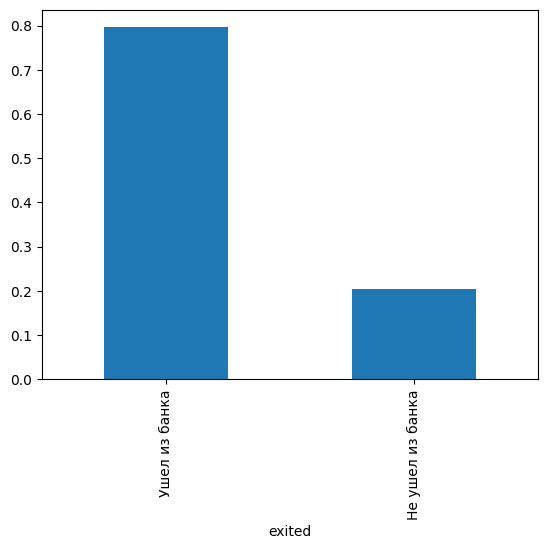

In [82]:
# Вспомним как распределены классы в исходном датасете
print(class_data)
class_data.plot(kind='bar');

0    0.885
1    0.115
Name: proportion, dtype: float64


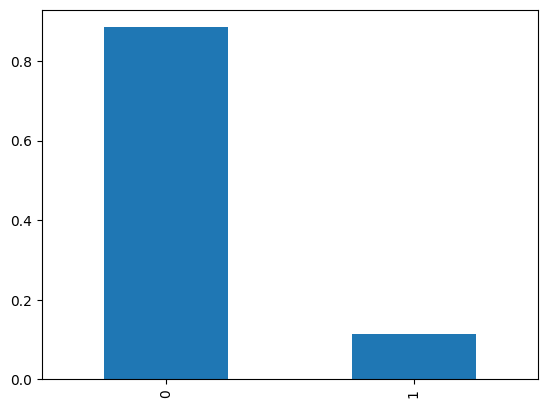

In [83]:
# Теперь посмотрим какие класс предсказывает модель случайного леса после downsampling
# чтобы функция value_counts() работала,надо преобразовать результат к pd.Series 
predicted_valid_forest = pd.Series(model_forest_down.predict(features_valid))

class_model_forest = predicted_valid_forest.value_counts(2/len(features_valid))
print(class_model_forest)
class_model_forest.plot(kind='bar');

> Модель хорошо предсказывает классы

<h1>Финальный вывод:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

*Downsampling* помог справиться с дисбалансом (upsampling сделал только хуже). После него на всех моделях увеличились значения метрик. Лучше всех показала себя модель случайного леса. 

*Проверка на тестовой выборке и проверка на вменямость доказали, что модель годится для решения поставленной задачи*